In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
c = Client()
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36489 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36489/status,
Dashboard: /proxy/36489/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35057,Workers: 7
Dashboard: /proxy/36489/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36699,Total threads: 1
Dashboard: /proxy/46595/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:34535,


### Functions

#### Your original functions:

In [6]:
# Define a function that returns the nearest lat/ lon grid point to a cyclone center
def nearest(point, vector):
    '''This function finds the nearest element in an array of latitude or longitude
    values to a given point.'''
    
    grid_point = min(vector, key=lambda x:abs(x-point))
    return grid_point

#### Vectorised functions:

Changed the 2 functions just to add a bit of vectorisation instead of loops. They produce the exact same result as before.

In [7]:
def nearest_vect(points, vector):
    '''This function finds the nearest elements in an array of latitude or longitude
    values to the given array of points using numpy's vectorized operations.'''
    
    abs_diff = np.abs(vector[:, None] - points)
    nearest_indices = np.argmin(abs_diff, axis=0)
    return vector[nearest_indices]

Explanation for nearest_vect():

```python
abs_diff = np.abs(vector[:, None] - points)
```
This computes the absolute differences between each value in the provided vector and all values in points using vectorization. ```vector[:, None]``` reshapes the vector array to a 2D array where each element is in a different row. The subtraction then broadcasts points across all rows of vector. The ```np.abs``` function takes an absolute value of the differences to get positive values.

```python
nearest_indices = np.argmin(abs_diff, axis=0)
```
After obtaining the matrix of absolute differences ```(abs_diff)```, the ```np.argmin()``` function finds the indices of the minimum values along the specified axis ```(0 - row-wise)```. These indices correspond to the elements in vector that are closest to each value in points.


```python
return vector[nearest_indices]
```
The function then utilizes these indices to return the elements in the vector array that are closest to each value in points.

In [8]:
# I didn't modify this code much, just put the IF statement into 1 line

def ints_to_str(numerical_values):
    '''This function transforms an array of integers into an array of 
    strings, adding leading zeros where necessary if the number 
    is less than 10.'''
    
    return ['0' + str(int(x)) if int(x) < 10 else str(int(x)) for x in numerical_values]

### Cyclone data

In [9]:
d = 15 # degrees lat/lon. The distance around the center of the weather systems that you want to 
        # extract and plot the data composite for. It needs to be an exact multiple of the reanalysis
        # spatial resolution (in this case 1.5 degree resolution data is used). 

# Open the files of dates and compute corresponding lists of time axis values
list_data_path = '/home/561/nxg561/00_Tracking_Scheme_Comparison/Output_Data/PGvsMU/'
input_filename = 'mu_only.txt'

lows_pd = pd.read_csv(list_data_path + input_filename, delimiter = ',', header = None)
lows_pd.columns = ['track', 'year', 'month', 'day', 'hour', 'tstep', 'lat', 'lon', 'z500', 'test1', 'test2']

# Get the year, month, day and hour columns as lists
yearstring_list = ints_to_str(list(lows_pd['year']))
monthstring_list = ints_to_str(list(lows_pd['month']))
daystring_list = ints_to_str(list(lows_pd['day']))
hourstring_list = ints_to_str(list(lows_pd['hour']))

# Combine the lists into a list of date strings
date_list = []
num_dates = len(yearstring_list)

for ii in range(num_dates):
    datestr = yearstring_list[ii] + '-' + monthstring_list[ii] + '-' + daystring_list[ii] + '-' + hourstring_list[ii]
    date_list.append(datestr)

# get arrays of the lat and lon values, to use for finding the nearest grid point to the cyclone centers
eraint_lats = np.arange(-90, 0, 1)
eraint_lons = np.arange(-180, 180, 1)

# Create series of the lat and lon values
lat_lower = np.zeros(num_dates)
lon_lower = np.zeros(num_dates)

# This part handles the cases where the identified cyclone centers do not match up exactly with the reanalysis grid
lat_lower = nearest_vect(lows_pd['lat'].values - d, eraint_lats)
lon_lower = nearest_vect(lows_pd['lon'].values - d, eraint_lons)

lat_upper = lat_lower + 2 * d
lon_upper = lon_lower + 2 * d

### ERA5 data

In [10]:
# Open the ERA5 geopotential height files as a multi-file dataset
era5_data_path = '/g/data/w40/nxg561/ERA-Int/z*.nc'

In [11]:
# We use this function to get xarray to pre-select info as each data file is opened. 
# It helps to reduce the work needed later.

def preprocessing(ds):
    # Pre-select the dimensions
    ds = ds.sel(lat = slice(10, -90), lon = slice(60, 180), lev=50000)
    # Select we want the z variable and divide it now. This reanalysis provides geopotential energy, so we divide by 9.8
    # to get meters. 
    ds = ds.z / 9.8
    
    return ds

In [12]:
%%time
z500 = xr.open_mfdataset(era5_data_path, parallel=True, preprocess=preprocessing, combine = 'nested', concat_dim = 'time', chunks={'time': 124, 'lat': -1, 'lon': -1})

CPU times: user 4.68 s, sys: 608 ms, total: 5.28 s
Wall time: 20.8 s


```parallel=True``` - This argument enables parallel I/O with Dask.

```preprocess=preprocessing``` - This applies the preprocessing function to each file upon opening.

```chunks={'time': 124, 'lat': -1, 'lon': -1}``` - This breaks the dataset down into smaller, manageable chunks along the specified dimensions.

In [36]:
# I don't think this is necessary here, the dataset is pretty small after preprocessing.
#z = xr_obj.chunk(chunks={'time': '70mb'})

In [13]:
%%time

# Now we load the data into memory since it's only 2.42Gb. 
# Loading now actually makes the loop later quicker.
# If this processed data was much bigger then we wouldn't compute now, we'd deploy Dask delayed on the loop
z500_load = z500.compute()

CPU times: user 15.4 s, sys: 4.21 s, total: 19.6 s
Wall time: 1min 59s


In [14]:
# create empty np.array of zeros to insert the system centered fields into
system_fields = np.zeros((num_dates, 2 * d + 1, 2 * d + 1))

In [15]:
%%time

# Loop through each date, extract the geopotential height data field for the cyclone center at that date, and write
# the field into the system fields array
for ii in range(num_dates):
    
    system_field = z500_load.sel(lat=slice(lat_upper[ii], lat_lower[ii]), lon=slice(lon_lower[ii], lon_upper[ii]), time=date_list[ii]).data
    
    system_fields[ii,:,:] = system_field

CPU times: user 4.45 s, sys: 323 ms, total: 4.77 s
Wall time: 4.61 s


In [16]:
%%time

# Compute the mean system-centered field
mean_system_field = np.mean(system_fields, axis = 0)

CPU times: user 7.88 ms, sys: 1.54 ms, total: 9.42 ms
Wall time: 6.94 ms


### plotting & saving


Text(0, 0.5, 'Center-Relative Latitude')

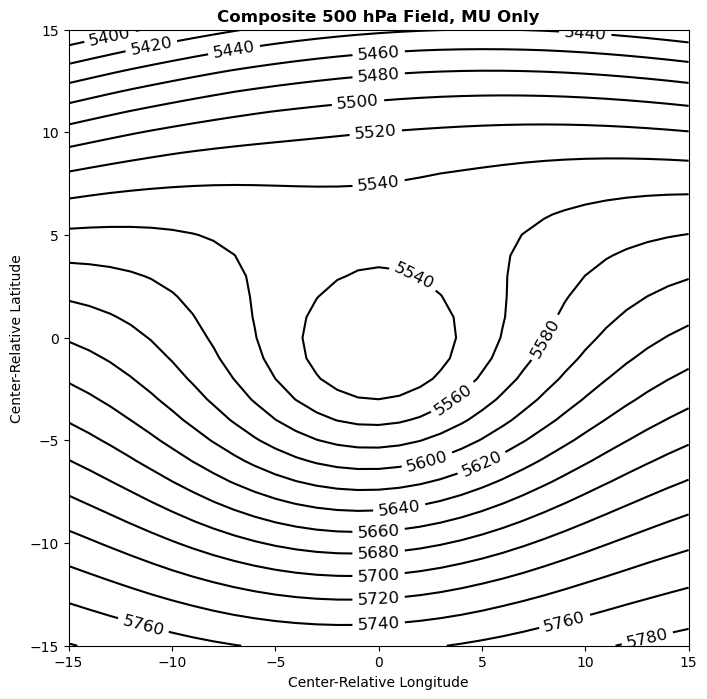

In [17]:
# Contour plot the mean system-centered field
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

# Create the grid to orient the contour plot
lat_vector = np.arange(-d,d+1,1)
lon_vector = np.arange(-d,d+1,1)

latall = np.meshgrid(lon_vector, lat_vector)[1]
lonall = np.meshgrid(lon_vector, lat_vector)[0]

# Call the contour plot method
graphic = ax.contour(lonall, latall, mean_system_field, 20, colors = 'k')

# Add contour labels   
ax.clabel(graphic, fontsize=12)

ax.set_title('Composite 500 hPa Field, MU Only', weight = 'bold')
ax.set_xlabel('Center-Relative Longitude')
ax.set_ylabel('Center-Relative Latitude')

In [49]:
# Save the graphic
fig.savefig(list_data_path + 'composite_mu_only.png', format = 'png')

In [28]:
# This only closes the files that have been opened, in our case we called this z
z.close()

# To actually remove the data from memory you need to run the following:
del z_load